In [14]:
#!ln -s /proyecto

# Memoria de Relevamiento

Se midieron con equipos GPS de simple frecuencia dos puntos que se denominaron
PFD1 y PFD2, y se vincularon a la estación permanente IGM1. En este apartado
se describe el procesamiento GPS, incluyendo la salida del programa de procesamiento. 

## Archivos de medición

Los archivos de medición se incluyen en formato Rinex 2.11, como

```
proyecto/PFD10240.20o
proyecto/PFD20240.20o
```

El archivo de medición de la estación IGM1 se obtuvo de la web del IGN, se incluye como

```
proyecto/igm10240.20o
```

## Datos de Sesion.

Los datos de la sesión, extraidos de los archivos de medición,
se completan en los anexos 4.1 que se adjuntan.

Se incluye también el anexo 4 con datos generales del trabajo.

In [15]:
FILEFLD = 'proyecto'
BASE = 'igm10240.20o'
PIE = 'PFD10240.20o'
AZIMUT = 'PFD20240.20o'

# Creación de Archivos de Sesiones

Se crean archivos para las dos sesiones de cada vector, Cortando los archivos 
con la herramienta RinEdit, del paquete GPSTk. Los tiempos se extraen también con
la herramienta RinSum, del paquete GPSTk

In [63]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import fillforms
import os.path

In [17]:
from itertools import repeat,cycle

In [18]:
import numbers
import pandas as pd
from math import cos
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import pyconf

DEG2RAD = 3.14159 / 180

totime = lambda x: np.datetime64(datetime(*x))

In [19]:
COLS = ["date","GPST", "latitude", "longitude","height","Q","ns","sdn","sde","sdu","sdne","sdeu","sdun","age","ratio"]

#to_GPSTk_time :: np.datetime64 -> String
def toGpstkTime(time):
    return '{},{},{},{},{},{}'.format(*time.astype(datetime).timetuple())

#path
def isRinex(path):
    result,*_ = !RinSum {path} | grep -q "This header is VALID" && echo True || echo False
    if result == "True":
        return True
    else:
        return False
    
#parse_times :: RinSum output -> [time,time,time]
def parse_times(rxSum):
    for i in rxSum:
        if m := re.match(r'.*first\s+epoch:\s+(\d+).(\d+).(\d+).*?(\d+).(\d+).(\d+).*?=.*?(\d+)\s+(\d+)\s+([\d\.]+)',i):
            ini_time = totime((int(i) for i in m.groups()[:6]))
        if m := re.match(r'.*last\s+epoch:\s+(\d+).(\d+).(\d+).*?(\d+).(\d+).(\d+).*?=.*?(\d+)\s+(\d+)\s+([\d\.]+)',i):
            end_time = totime((int(i) for i in m.groups()[:6]))
    medio_st = (ini_time + (end_time-ini_time)/2)
    
    return {'start':ini_time,'mid':medio_st,'end':end_time}
    
class DataFile(object):
    def __init__(self,file):
        self.path = file
        self.p1path = None
        self.p2path = None
        self._sumary = !RinSum {self.path}
        self.times = parse_times(self._sumary)
        self.sess = {}
        self.sessData = {}

        
    def mid_split(self,folder):
        file = os.path.basename(self.path)
        self.p1path = os.path.join(folder,file.replace('0.','1.'))
        self.p2path = os.path.join(folder,file.replace('0.','2.'))
        m = toGpstkTime(self.times['mid'])
        
        !RinEdit --IF {self.path} --OF {self.p1path} --TE {m}
        !RinEdit --IF {self.path} --OF {self.p2path} --TB {m}
        
        if isRinex(self.p1path) and isRinex(self.p2path):
            return True
        else:
            raise ValueError('Split Failed')
            
    def _compute_pdop(self,nav=None,part=0):

        path = {0:self.path,1:self.p1path,2:self.p2path}.get(part,None)
        
        if path is None:
            raise ValueError('Attemp to read an uninitialized part')

        basepath = '.'.join(path.split('.')[:-1])
        basedir = os.path.join(os.path.dirname(basepath),'single-sols')
        !mkdir -p {basedir}

        basepath = os.path.join(basedir,os.path.basename(basepath))
        
        if nav is None:
            nav = path[:-1]+'n'

        !PRSolve --obs {path} --nav {nav} --sol GPS:1:C --log {basepath}.sol
        !grep "RPF GPS:1:C RMS" {basepath}.sol > {basepath}.sol.stats

        with open('{}.sol.stats'.format(basepath),'r') as f:
            fstline = f.readline()
        
        #!echo "{fstline.split()[3]} {fstline.split()[4]}"
        #!timeconvert --ws "{fstline.split()[3]} {fstline.split()[4]}" -F "%Y %m %d %H %M %S"
        
        out,*_ = !timeconvert --ws "{fstline.split()[3]} {fstline.split()[4]}" -F "%Y %m %d %H %M %S"
        initime = totime([int(i) for i in out.split()])
        
        PDOP = pd.read_fwf('{}.sol.stats'.format(basepath),header=None).set_index(4).loc[:,8]

        PDOP.index = initime + (PDOP.index - PDOP.index[0]) * np.timedelta64(1,'s')
        
        return PDOP
    
    def store_pdops(self,nav=None):
        self.pdop = self._compute_pdop(nav=nav,part=0)
        try:
            self.p1pdop = self._compute_pdop(nav=nav,part=1)
            self.p2pdop = self._compute_pdop(nav=nav,part=2)
        except ValueError as e:
            print('WARNING:{}'.format(e))
        
        return True

    def _pdop_filter(self,max_pdop=2.5):
    
        malos = self.pdop[self.pdop > max_pdop].index

        starts = malos[1:][((malos[1:]-malos[:-1]) / np.timedelta64(1,'s')).values > 1]
        starts = pd.Index(np.concatenate([malos[:1],starts]))
        stops = malos[:-1][((malos[1:]-malos[:-1]) / np.timedelta64(1,'s')).values > 1]
        stops = pd.Index(np.concatenate([stops,malos[-1:]]))

        breaks = []
        for b,e in zip(starts,stops):
            b=np.datetime64(b)
            e=np.datetime64(e)
            if e == b:
                breaks.append('--DA {}'.format(toGpstkTime(b)))
            else:
                breaks.append('--DA+ {} --DA- {}'.format(toGpstkTime(b),toGpstkTime(e+np.timedelta64(1,'s'))))

        basedir = os.path.join(os.path.dirname(self.path),'pdop-cleaned')
        !mkdir -p {basedir}
        
        outpath = os.path.join(basedir,os.path.basename(self.path))
    
        !RinEdit --IF {self.path} --OF {outpath} {' '.join(breaks)}

        return DataFile(outpath)
    
    def process(self,base,conf,sp3=[],nav=None,session=None,folder=None):
        if session == None:
            for i in range(3):
                self.process(base,conf,session=i,sp3=sp3,nav=nav,folder=folder)
            return True
        
        path = {0:self.path,1:self.p1path,2:self.p2path}.get(session,None)

        if path is None:
            raise ValueError('Attemp to read an uninitialized part')

        basepath = '.'.join(path.split('.')[:-1])
            
        if nav is None:
            nav = path[:-1]+'n'

        if folder == None:
            folder = os.path.join(os.path.dirname(self.path),'sesiones')
        
        !mkdir -p {folder}
            
        punto = path
        base = base.path
        eph = ' '.join(['{}'.format(i) for i in set(sp3files)])
        sessname = '{}-{}-{}'.format(os.path.basename(base)[:4],
                                     os.path.basename(path)[:4],session)
        output = os.path.join(folder,sessname)
        
        !echo rnx2rtkp -k {conf} {punto} {base} {nav} {eph} -o {output}-fw.txt
        !rnx2rtkp -k {conf} {punto} {base} {nav} {eph} -o {output}-fw.txt
        
        self.sess['{}-fw'.format(session)] = '{}-fw.txt'.format(output)

        !echo rnx2rtkp -b -k {conf} {punto} {base} {nav} {eph} -o {output}-bw.txt
        !rnx2rtkp -b -k {conf} {punto} {base} {nav} {eph} -o {output}-bw.txt

        self.sess['{}-bw'.format(session)] = '{}-bw.txt'.format(output)
        
        return True
    
    def reloadProcesed(self):
        for k,v in self.sess.items():
            sess = pd.read_fwf(v,comment='%',names=COLS,index=None)
            sess = sess.set_index((sess.date + 'T' + sess.GPST)\
                                  .map(lambda x: np.datetime64(x.replace('/','-'))))
            self.sessData[k] = sess
        
        return True           

In [20]:
datos = {}

for i,k in zip([BASE, PIE, AZIMUT],['base','pie','azimut']):
    archivo = os.path.join(FILEFLD,i)
    f = DataFile(archivo)
    datos[k] = f

REFNAV = datos['base'].path[:-1]+'n'
    
# TRIM PDOP > 2.5
for k in ['pie','azimut']:
    datos[k].store_pdops(nav=REFNAV)
    datos[k] = datos[k]._pdop_filter()

Output redirected to log file proyecto/single-sols/PFD10240.sol
PRSolve timing: processing 20.597 sec, wallclock: 21 sec.
# RinEdit, part of the GPS Toolkit, Ver 2.4 9/23/15 rev, Run 2021/04/05 23:16:31
Reading header...
# Header ObsIDs GPS (3): L1C C1C D1C
Reading observations...
 Opened output file proyecto/pdop-cleaned/PFD10240.20o at time 2020/01/24 18:35:15 = 2089 498915.000 GPS
 Close output file.
RinEdit timing: processing 2.412 sec, wallclock: 3 sec.
Output redirected to log file proyecto/single-sols/PFD20240.sol
PRSolve timing: processing 20.362 sec, wallclock: 20 sec.
# RinEdit, part of the GPS Toolkit, Ver 2.4 9/23/15 rev, Run 2021/04/05 23:16:56
Reading header...
# Header ObsIDs GPS (3): L1C C1C D1C
Reading observations...
 Opened output file proyecto/pdop-cleaned/PFD20240.20o at time 2020/01/24 19:37:31 = 2089 502651.000 GPS
 Close output file.
RinEdit timing: processing 2.127 sec, wallclock: 3 sec.


In [21]:
SPLITPATH = os.path.join(FILEFLD,'splits')

!mkdir -p {SPLITPATH}

for k,v in datos.items():
    if k == 'base':
        continue
    else:
        v.mid_split(folder=SPLITPATH)
        v.store_pdops(nav=datos['base'].path[:-1]+'n')

# RinEdit, part of the GPS Toolkit, Ver 2.4 9/23/15 rev, Run 2021/04/05 23:17:00
   End time --end is 2089,508305.000000 = 2020,1,24,21,11,45
Reading header...
# Header ObsIDs GPS (3): L1C C1C D1C
Reading observations...
 Opened output file proyecto/splits/PFD10241.20o at time 2020/01/24 18:35:15 = 2089 498915.000 GPS
 Close output file.
RinEdit timing: processing 1.108 sec, wallclock: 1 sec.
# RinEdit, part of the GPS Toolkit, Ver 2.4 9/23/15 rev, Run 2021/04/05 23:17:01
   Begin time --begin is 2089,508305.000000 = 2020,1,24,21,11,45
Reading header...
# Header ObsIDs GPS (3): L1C C1C D1C
Reading observations...
 Opened output file proyecto/splits/PFD10242.20o at time 2020/01/24 21:11:45 = 2089 508305.000 GPS
 Close output file.
RinEdit timing: processing 1.550 sec, wallclock: 2 sec.
Output redirected to log file proyecto/pdop-cleaned/single-sols/PFD10240.sol
PRSolve timing: processing 20.244 sec, wallclock: 20 sec.
Output redirected to log file proyecto/splits/single-sols/PFD10241.so

In [22]:
datos['base'].store_pdops(nav=datos['base'].path[:-1]+'n')

Output redirected to log file proyecto/single-sols/igm10240.sol
PRSolve timing: processing 34.075 sec, wallclock: 34 sec.


True

# Gráficas del PDOP

Con la herramienta PRSolve, parte de GPSTk, se calculó el PDOP para cada época de las sesiones. El mismo 
se grafica a continuación (en un gráfico por cada sesión, incluyendo los datos de ambas estaciones).

Se calculó el PDOP máximo y medio en cada caso.

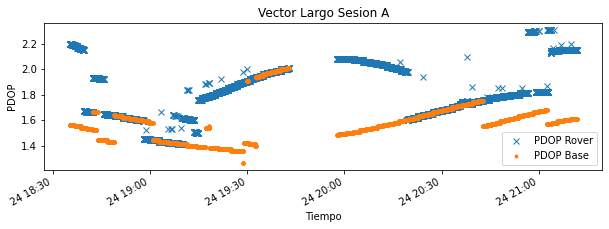

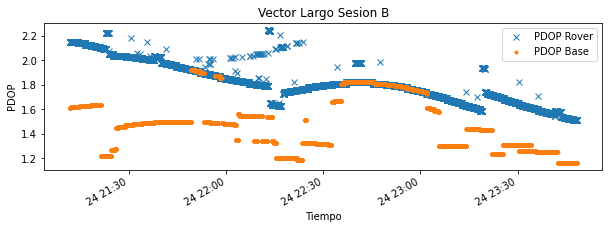

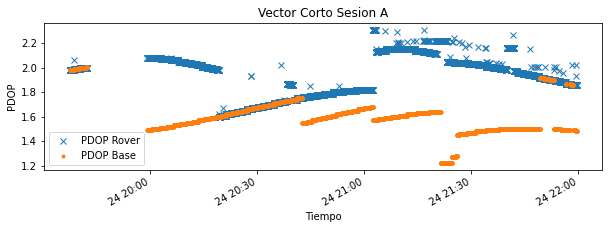

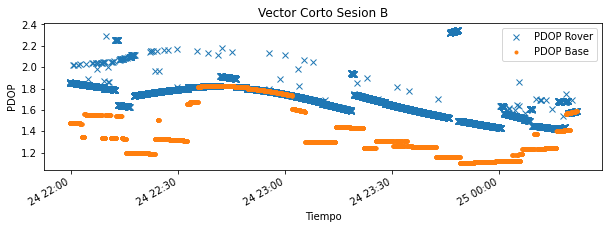

In [23]:
for doprover,dopbase,titulo in zip(
    [datos['pie'].p1pdop,datos['pie'].p2pdop,datos['azimut'].p1pdop,datos['azimut'].p2pdop],
    repeat(datos['base'].pdop),
    ['Vector Largo Sesion A','Vector Largo Sesion B',
     'Vector Corto Sesion A','Vector Corto Sesion B']):
    
    fig,ax = plt.subplots(figsize=(10,3))
    doprover.plot(style='x',ax=ax,label='PDOP Rover')
    dopbase.reindex(doprover.index).plot(style='.',ax=ax,label='PDOP Base')
    ax.set_title(titulo)
    ax.legend()
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("PDOP")
    plt.show()

# Con esta información se generaron los Anexos 4 y 4.1

In [24]:
filesinfo = fillforms.get_rx_data(datos['base'].path,
                                  datos['pie'].p1path,
                                  datos['pie'].p2path )
fillforms.make_template(filesinfo,template_file='./Anexo4.1.fdf')

In [25]:
kwargs = {
    'pdf_file':'./Anexo4.1.pdf',
    'fdf_file':'./4.1.tmp.fdf',
    'base':BASE[:4],
    'punto':PIE[:4]
}
fillforms.apply_template(**kwargs)

# Antenas:

Las antenas utilizadas, modelo NAP100 de Ashtech, que son las antenas originales del equipo Promark 3, no se encuentran en el archivo de información de antena del software de procesamiento RTKLIB, los parámetros utilizados, extraidos de la información que viene grabada en la antena, están a continuación y son agregados al archivo de antenas para poder realizar el cálculo.

El formato del archivo es el siguiente:
https://kb.igs.org/hc/en-us/articles/216104678-ANTEX-format-description

Los datos agregados Son:
```      
                                                            START OF ANTENNA    
NAP100          NONE                                        TYPE / SERIAL NO    
FIELD               JJC                      0    02-DIC-20 METH / BY / # / DATE
     0.0                                                    DAZI                
     0.0  80.0   5.0                                        ZEN1 / ZEN2 / DZEN  
     1                                                      # OF FREQUENCIES    
CONVERTED FROM RELATIVE NGS ANTENNA CALIBRATIONS            COMMENT             
   G01                                                      START OF FREQUENCY  
      0.00      0.00     73.00                              NORTH / EAST / UP   
   G01                                                      END OF FREQUENCY    
                                                            END OF ANTENNA      
```      
                                                            



In [26]:
antenaNAP100 = \
"""
                                                            START OF ANTENNA    
NAP100          NONE                                        TYPE / SERIAL NO    
FIELD               JJC                      0    02-DIC-20 METH / BY / # / DATE
     0.0                                                    DAZI                
     0.0  80.0   5.0                                        ZEN1 / ZEN2 / DZEN  
     1                                                      # OF FREQUENCIES    
CONVERTED FROM RELATIVE NGS ANTENNA CALIBRATIONS            COMMENT             
   G01                                                      START OF FREQUENCY  
      0.00      0.00     73.00                              NORTH / EAST / UP   
   G01                                                      END OF FREQUENCY    
                                                            END OF ANTENNA
EOF
"""
!cat /rtklib/data/igs05.atx - <<EOF > /rtklib/data/antenas.atx $antenaNAP100

In [27]:
with open('/proyecto/conf.cfg','r') as f:
    confs = {i.strip():j.strip() for i,j in [k.split('=') for k in f.readlines()]}
    
    for i in pyconf.formulario.children:
        try:
            if i.description == 'pos1-navsys':
                continue
            
            opts = [j.split(':')[1] for j in i.options]
            optsn = [j.split(':')[0] for j in i.options]
            
            if (val := confs[i.description]) in opts:
                i.value = i.options[opts.index(val)]
            elif (val := confs[i.description]) in optsn:
                i.value = i.options[optsn.index(val)]
        except AttributeError:
            if isinstance(i.value,int):
                if confs[i.description] == '':
                    i.value = -1
                else:
                    i.value = int(confs[i.description])
            elif isinstance(i.value,str):
                i.value = confs[i.description]
            elif isinstance(i.value,float):
                i.value = float(confs[i.description])
                if confs[i.description] == '':
                    i.value = -1

In [28]:
pyconf.formulario

GridspecLayout(children=(Dropdown(description='pos1-posmode', index=3, layout=Layout(grid_area='widget001'), o…

In [29]:
import numbers

with open('/proyecto/conf.cfg','w') as f:
    for i in pyconf.formulario.children:
        try:
            if isinstance(i.value, (list, tuple)):
                value = sum([int(v.split(':')[0]) for v in i.value if v.split(':')[0] != ''])
            else:
                value = i.value.split(':')[-1]
                
            try:
                if int(value) < 0: # -1 is blank
                    value = ''
            except ValueError:
                pass
            
        except AttributeError:
            value = i.value
            try:
                if int(value) < 0: # -1 is blank
                    value = ''
            except ValueError:
                pass

        print('{} ={}'.format(i.description,value),file=f)

In [30]:
cat /proyecto/conf.cfg

pos1-posmode =static
pos1-frequency =l1
pos1-soltype =forward
pos1-elmask =10
pos1-snrmask =
pos1-dynamics =on
pos1-tidecorr =on
pos1-ionoopt =off
pos1-tropopt =saas
pos1-sateph =brdc
pos1-exclsats =
pos1-navsys =1
pos2-armode =fix-and-hold
pos2-gloarmode =on
pos2-arthres =3
pos2-arlockcnt =60
pos2-arelmask =15
pos2-aroutcnt =1
pos2-arminfix =120
pos2-elmaskhold =20
pos2-slipthres =0.05
pos2-maxage =30
pos2-rejionno =30
pos2-niter =5
pos2-baselen =
pos2-basesig =
out-solformat =llh
out-outhead =on
out-outopt =on
out-timesys =gpst
out-timeform =hms
out-timendec =3
out-degform =deg
out-fieldsep =
out-height =ellipsoidal
out-geoid =internal
out-solstatic =all
out-nmeaintv1 =
out-nmeaintv2 =
out-outstat =residual
stats-errratio =100
stats-errphase =0.003
stats-errphaseel =0.003
stats-errphasebl =
stats-errdoppler =10
stats-stdbias =30
stats-stdiono =0.03
stats-stdtrop =0.6
stats-prnaccelh =0.01
stats-prnaccelv =0.001
stats-prnbias =0.0001
stats-prniono =0.001
stats-prntrop =0.0001
stats-cl

In [31]:
!mkdir -p sp3

In [32]:
import urllib.request as urlreq

In [33]:
import subprocess

In [34]:
sp3files = []

def saveSp3(w,d,folder='sp3'):
    url = "ftp://gssc.esa.int/gnss/products/{}/igs{}.sp3.Z".format(w,d)
    weburl = urlreq.urlopen(url)
    data= weburl.read()
    dest_path= "{}/igs{}.sp3".format(folder,d)
    with open(dest_path,'bw') as f:
        subprocess.run("gunzip",input=data,stdout=f)
    sp3files.append(dest_path)

In [35]:
ini_time = toGpstkTime(datos['base'].times['start'])
gpsday,*_ = !timeconvert --input-format="%Y,%m,%d,%H,%M,%S" --input-time="{ini_time}" -F "%F %w"

ini_gpsw,ini_gpsdow = [int(i) for i in gpsday.split()]

w = '{}'.format(ini_gpsw) 
d = '{}{}'.format(ini_gpsw,ini_gpsdow)
saveSp3(w,d)

if ini_gpsdow == 0:
    w = '{}'.format(ini_gpsw-1) 
    d = '{}{}'.format(ini_gpsw-1,6)
    saveSp3(w,d)
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw,1)
    saveSp3(w,d)   
elif ini_gpsdow == 6:
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw,5)
    saveSp3(w,d)
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw+1,0)
    saveSp3(w,d)
else:
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw,ini_gpsdow+1)
    saveSp3(w,d)
    w = '{}'.format(ini_gpsw) 
    d = '{}{}'.format(ini_gpsw,ini_gpsdow-1)
    saveSp3(w,d)   

In [36]:
datos['pie'].process(datos['base'],'proyecto/conf.cfg',sp3=sp3files,nav=REFNAV)

rnx2rtkp -k proyecto/conf.cfg proyecto/pdop-cleaned/PFD10240.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20894.sp3 sp3/igs20895.sp3 sp3/igs20896.sp3 -o proyecto/pdop-cleaned/sesiones/igm1-PFD1-0-fw.txt
rnx2rtkp -b -k proyecto/conf.cfg proyecto/pdop-cleaned/PFD10240.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20894.sp3 sp3/igs20895.sp3 sp3/igs20896.sp3 -o proyecto/pdop-cleaned/sesiones/igm1-PFD1-0-bw.txt
rnx2rtkp -k proyecto/conf.cfg proyecto/splits/PFD10241.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20894.sp3 sp3/igs20895.sp3 sp3/igs20896.sp3 -o proyecto/pdop-cleaned/sesiones/igm1-PFD1-1-fw.txt
rnx2rtkp -b -k proyecto/conf.cfg proyecto/splits/PFD10241.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20894.sp3 sp3/igs20895.sp3 sp3/igs20896.sp3 -o proyecto/pdop-cleaned/sesiones/igm1-PFD1-1-bw.txt
rnx2rtkp -k proyecto/conf.cfg proyecto/splits/PFD10242.20o proyecto/igm10240.20o proyecto/igm10240.20n sp3/igs20894.sp3 sp3/igs20895.sp3 sp3/igs20896.sp3 

True

In [37]:
datos['pie'].reloadProcesed()

True

In [38]:
datos['pie'].sessData.keys()

dict_keys(['0-fw', '0-bw', '1-fw', '1-bw', '2-fw', '2-bw'])

In [46]:
def plot_latitude(sess, ax=None,filtro=lambda x: x.iloc[len(x)//2:],**kwargs):
    if ax is None:
        fig,ax = plt.subplots()
    filtro(sess.latitude * DEG2RAD * 6.4e6).plot(ax=ax,**kwargs)
    return ax

def plot_longitude(sess, ax=None,filtro=lambda x: x.iloc[len(x)//2:],**kwargs):
    reflat = sess.latitude.median()
    cosreflat = cos(reflat * DEG2RAD)

    if ax is None:
        fig,ax = plt.subplots()
    
    filtro(sess.longitude * DEG2RAD * cosreflat * 6.4e6).plot(ax=ax,**kwargs)
    return ax

def plot_height(sess, ax=None,filtro=lambda x: x.iloc[len(x)//2:],**kwargs):

    if ax is None:
        fig,ax = plt.subplots()
    
    filtro(sess.height).plot(ax=ax,**kwargs)
    return ax

def plot_track(sess, ax=None,filtro=lambda x: x.iloc[len(x)//2:],**kwargs):
    reflat = sess.latitude.median()
    cosreflat = cos(reflat * DEG2RAD)

    if ax is None:
        fig,ax = plt.subplots()
    
    ax.plot(filtro(sess).longitude * DEG2RAD * cosreflat * 6.4e6,
             filtro(sess).latitude * DEG2RAD * 6.4e6,**kwargs)

    ax.set_aspect('equal')
    return ax

def plot_last(sess, ax=None,filtro=lambda x: x.iloc[len(x)//2:],**kwargs):
    reflat = sess.latitude.median()
    cosreflat = cos(reflat * DEG2RAD)

    if ax is None:
        fig,ax = plt.subplots()
    
    ax.plot(sess.longitude[-1] * DEG2RAD * cosreflat * 6.4e6,
            sess.latitude[-1] * DEG2RAD * 6.4e6,**kwargs)
    
    ax.set_aspect('equal')
    return ax

def plot_tracks(sessions,filtro=lambda x: x.iloc[len(x)//2:]):
    fig,ax = plt.subplots()
    for sess,mk1,mk2 in zip(sessions,cycle(['x','.','^']),cycle(['>','o','^'])):
        plot_track(sess,ax=ax,filtro=filtro,marker=mk1,alpha=0.05)
        plot_last(sess,ax=ax,marker=mk2,markersize=15)

    plt.show()
    

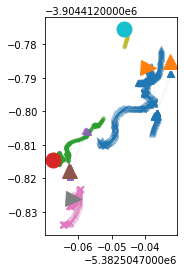

In [47]:
plot_tracks(datos['pie'].sessData.values(),filtro=lambda x: x.iloc[len(x)*3//4:])

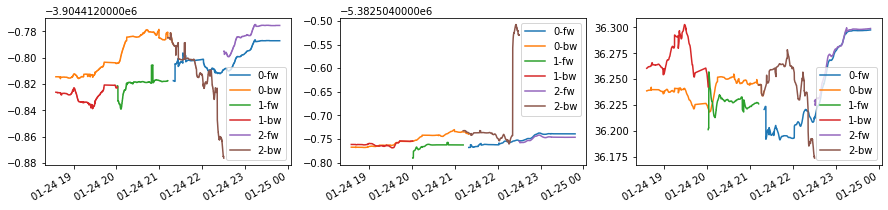

In [64]:
fig, ax = plt.subplots(1,3,figsize=(15,3))

ax1,ax2,ax3 = ax.flatten()

for k,s in datos['pie'].sessData.items():
    plot_latitude(s,label=k,ax=ax1)
    plot_longitude(s,label=k,ax=ax2)
    plot_height(s,label=k,ax=ax3)
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [278]:
PFD1_A = pd.Series({'latitud':sessA.latitude[-1],'longitud':sessA.longitude[-1],'altura':sessA.height[-1]})
PFD1_B = pd.Series({'latitud':sessB.latitude[-1],'longitud':sessB.longitude[-1],'altura':sessB.height[-1]})
PFD1_C = pd.Series({'latitud':sessC.latitude[-1],'longitud':sessC.longitude[-1],'altura':sessC.height[-1]})

In [279]:
sesiones_string = \
"""
{latitud} {longitud} {altura}""".format(**PFD1_A) +\
"""
{latitud} {longitud} {altura}""".format(**PFD1_B) +\
"""
{latitud} {longitud} {altura}""".format(**PFD1_C) +\
"""
EOF
"""

!proj -f %.3f +proj=tmerc +ellps=GRS80 +lat_0=-90 +lon_0=-60 +x_0=5500000 +no_defs << EOF $sesiones_string

6925680.709	3209257.567 36.2262
6925680.747	3209257.603 36.2989
6925680.737	3209257.595 36.2975


In [280]:
PFD1_Ab = pd.Series({'latitud':sessAb.latitude[-1],'longitud':sessAb.longitude[-1],'altura':sessAb.height[-1]})
PFD1_Bb = pd.Series({'latitud':sessBb.latitude[-1],'longitud':sessBb.longitude[-1],'altura':sessBb.height[-1]})
PFD1_Cb = pd.Series({'latitud':sessCb.latitude[-1],'longitud':sessCb.longitude[-1],'altura':sessCb.height[-1]})

In [281]:
sesiones_string = \
"""
{latitud} {longitud} {altura}""".format(**PFD1_Ab) +\
"""
{latitud} {longitud} {altura}""".format(**PFD1_Bb) +\
"""
{latitud} {longitud} {altura}""".format(**PFD1_Cb) +\
"""
EOF
"""

!proj -f %.3f +proj=tmerc +ellps=GRS80 +lat_0=-90 +lon_0=-60 +x_0=5500000 +no_defs << EOF $sesiones_string

6925680.703	3209257.564 36.2605
6925680.741	3209257.601 36.2444
6925680.712	3209257.570 36.2387


In [282]:
print('{latitud:13.9f} {longitud:14.9f} {altura:9.3f}  PFD1  PFD1'.format(**PFD1_C))

-34.954150491  -58.792189346    36.297  PFD1  PFD1


In [283]:
with open('/rtklib/data/ramsac.pos','a+') as f:
    print('{latitud:13.9f} {longitud:14.9f} {altura:9.3f}  PFD1  PFD1'.format(**PFD1_C),file=f)

# Vector de Orientación

In [284]:
try:
    with open('/proyecto/conf2.cfg','r') as f:
        confs = {i.strip():j.strip() for i,j in [k.split('=') for k in f.readlines()]}

        for i in pyconf.formulario.children:
            try:
                if i.description == 'pos1-navsys':
                    continue

                opts = [j.split(':')[1] for j in i.options]
                optsn = [j.split(':')[0] for j in i.options]

                if (val := confs[i.description]) in opts:
                    i.value = i.options[opts.index(val)]
                elif (val := confs[i.description]) in optsn:
                    i.value = i.options[optsn.index(val)]
            except AttributeError:
                if isinstance(i.value,int):
                    if confs[i.description] == '':
                        i.value = -1
                    else:
                        i.value = int(confs[i.description])
                elif isinstance(i.value,str):
                    i.value = confs[i.description]
                elif isinstance(i.value,float):
                    i.value = float(confs[i.description])
                    if confs[i.description] == '':
                        i.value = -1
except FileNotFoundError:
    pass

In [285]:
pyconf.formulario

GridspecLayout(children=(Dropdown(description='pos1-posmode', index=3, layout=Layout(grid_area='widget001'), o…

In [286]:
import numbers

with open('/proyecto/conf2.cfg','w') as f:
    for i in pyconf.formulario.children:
        try:
            if isinstance(i.value, (list, tuple)):
                value = sum([int(v.split(':')[0]) for v in i.value if v.split(':')[0] != ''])
            else:
                value = i.value.split(':')[-1]
                
            try:
                if int(value) < 0: # -1 is blank
                    value = ''
            except ValueError:
                pass
            
        except AttributeError:
            value = i.value
            try:
                if int(value) < 0: # -1 is blank
                    value = ''
            except ValueError:
                pass

        print('{} ={}'.format(i.description,value),file=f)

In [287]:
rinex_info2 = !RinSum /proyecto/PFD20240.20o
print('\n'.join(rinex_info2))

# RinSum, part of the GPS Toolkit, Ver 4.1 8/26/15, Run 2021/04/05 20:34:37
+++++++++++++ RinSum summary of Rinex obs file /proyecto/PFD20240.20o +++++++++++++
---------------------------------- REQUIRED ----------------------------------
Rinex Version  2.11,  File type O,  System G (GPS).
Prgm: JJC Open Gps Read,  Run: 22 - OCT - 20 21:16,  By: Javier Clavijo
Marker name: PFD2, Marker type: .
Observer : Raul Clavijo,  Agency: RyJClavijo
Rec#: 3E302069,  Type: PromarkXCM,  Vers: 
Antenna # : 200721052,  Type : NAP100
Position      (XYZ,m) : (0.0000, 0.0000, 0.0000).
Antenna Delta (HEN,m) : (1.4990, 0.0000, 0.0000).
GPS Observation types (3):
 Type #01 (L1C) L1 GPSC/A phase
 Type #02 (C1C) L1 GPSC/A pseudorange
 Type #03 (D1C) L1 GPSC/A doppler
R2ObsTypes: L1 C1 D1 
mapSysR2toR3ObsID[G] C1:C1C D1:D1C L1:L1C 
Time of first obs 2020/01/24 19:37:31.000 GPS
(This header is VALID)
---------------------------------- OPTIONAL ----------------------------------
Signal Strenth Unit = 
Interval =

In [44]:
for i in rinex_info2:
    if m := re.match(r'.*first\s+epoch:\s+(\d+).(\d+).(\d+).*?(\d+).(\d+).(\d+).*',i):
        ini_time2 = totime((int(i) for i in m.groups()))
        print('Epoca inicial: ',m.groups())
    if m := re.match(r'.*last\s+epoch:\s+(\d+).(\d+).(\d+).*?(\d+).(\d+).(\d+).*',i):
        end_time2 = totime((int(i) for i in m.groups()))
        print('Epoca final: ',m.groups())

Epoca inicial:  ('2020', '01', '24', '19', '37', '31')
Epoca final:  ('2020', '01', '25', '00', '21', '47')


In [288]:
punto = datos['azimut'].p1path
base =  datos['pie'].path
#nav = '{}/{}'.format(FILEFLD,splitfiles[0][0])[:-1] + 'n'
#eph = '{} {} {}'.format(*set(sp3files))

In [289]:
!echo rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2A.txt
!rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2A.txt

!echo rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2A-b.txt
!rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2A-b.txt

rnx2rtkp -k proyecto/conf2.cfg proyecto/splits/PFD20241.20o.clean proyecto/PFD10240.20o.clean proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20895.sp3 sp3/igs20894.sp3 -o Sesion2A.txt
rnx2rtkp -b -k proyecto/conf2.cfg proyecto/splits/PFD20241.20o.clean proyecto/PFD10240.20o.clean proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20895.sp3 sp3/igs20894.sp3 -o Sesion2A-b.txt


In [290]:
punto = datos['azimut'].p2path

In [291]:
!echo rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2B.txt
!rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2B.txt

!echo rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2B-b.txt
!rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2B-b.txt

rnx2rtkp -k proyecto/conf2.cfg proyecto/splits/PFD20242.20o.clean proyecto/PFD10240.20o.clean proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20895.sp3 sp3/igs20894.sp3 -o Sesion2B.txt
rnx2rtkp -b -k proyecto/conf2.cfg proyecto/splits/PFD20242.20o.clean proyecto/PFD10240.20o.clean proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20895.sp3 sp3/igs20894.sp3 -o Sesion2B-b.txt


In [292]:
punto = datos['azimut'].path

In [293]:
!echo rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2C.txt
!rnx2rtkp -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2C.txt

!echo rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2C-b.txt
!rnx2rtkp -b -k {FILEFLD}/conf2.cfg {punto} {base} {nav} {eph} -o Sesion2C-b.txt

rnx2rtkp -k proyecto/conf2.cfg proyecto/PFD20240.20o.clean proyecto/PFD10240.20o.clean proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20895.sp3 sp3/igs20894.sp3 -o Sesion2C.txt
rnx2rtkp -b -k proyecto/conf2.cfg proyecto/PFD20240.20o.clean proyecto/PFD10240.20o.clean proyecto/igm10240.20n sp3/igs20896.sp3 sp3/igs20895.sp3 sp3/igs20894.sp3 -o Sesion2C-b.txt


In [294]:
sess2A = pd.read_fwf('Sesion2A.txt',comment='%',names=cols,index=None)
sess2A = sess2A.set_index((sess2A.date + 'T' + sess2A.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))
sess2B = pd.read_fwf('Sesion2B.txt',comment='%',names=cols,index=None)
sess2B = sess2B.set_index((sess2B.date + 'T' + sess2B.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))
sess2C = pd.read_fwf('Sesion2C.txt',comment='%',names=cols,index=None)
sess2C = sess2C.set_index((sess2C.date + 'T' + sess2C.GPST).map(lambda x: np.datetime64(x.replace('/','-'))))

session2A:-34.945944384,session2B:-34.945944346,session2C:-34.945944374


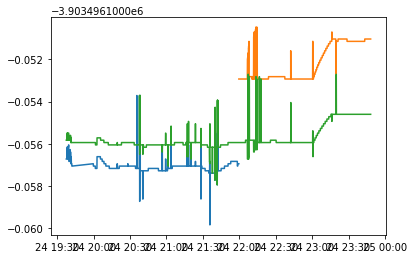

In [295]:
fig,ax = plt.subplots()
ax.plot(sess2A.index,(sess2A.latitude * DEG2RAD * 6.4e6).values)
ax.plot(sess2B.index,(sess2B.latitude * DEG2RAD * 6.4e6).values)
ax.plot(sess2C.index,(sess2C.latitude * DEG2RAD * 6.4e6).values)

print('session2A:{},session2B:{},session2C:{}'.format(*[i.latitude.median() for i in (sess2A,sess2B,sess2C)]))

plt.show()

session2A:-58.78297562,session2B:-58.782975571,session2C:-58.782975603


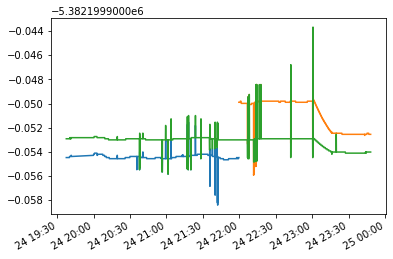

In [296]:
reflat = sess2A.latitude.median()
cosreflat = cos(reflat * DEG2RAD)

(sess2A.longitude * DEG2RAD * cosreflat * 6.4e6).plot()
(sess2B.longitude * DEG2RAD * cosreflat * 6.4e6).plot()
(sess2C.longitude * DEG2RAD * cosreflat * 6.4e6).plot()

print('session2A:{},session2B:{},session2C:{}'.format(*[i.longitude.median() for i in (sess2A,sess2B,sess2C)]))

plt.show()

session2A:40.2931,session2B:40.2798,session2C:40.2869


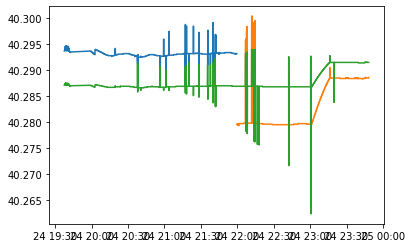

In [297]:
fig,ax = plt.subplots()
ax.plot(sess2A.index,(sess2A.height).values)
ax.plot(sess2B.index,(sess2B.height).values)
ax.plot(sess2C.index,(sess2C.height).values)

print('session2A:{},session2B:{},session2C:{}'.format(*[i.height.median() for i in (sess2A,sess2B,sess2C)]))

plt.show()

In [298]:
PFD2_A = pd.Series({'latitud':sess2A.latitude[-1],'longitud':sess2A.longitude[-1],'altura':sess2A.height[-1]})
PFD2_B = pd.Series({'latitud':sess2B.latitude[-1],'longitud':sess2B.longitude[-1],'altura':sess2B.height[-1]})
PFD2_C = pd.Series({'latitud':sess2C.latitude[-1],'longitud':sess2C.longitude[-1],'altura':sess2C.height[-1]})

In [299]:
sesiones_string = \
"""
{longitud} {latitud} {altura}""".format(**PFD2_A) +\
"""
{longitud} {latitud} {altura}""".format(**PFD2_B) +\
"""
{longitud} {latitud} {altura}""".format(**PFD2_C) +\
"""
EOF
"""

!proj -f %.3f +proj=tmerc +ellps=GRS80 +lat_0=-90 +lon_0=-60 +x_0=5500000 +no_defs << EOF $sesiones_string

5611175.841	6132693.366 40.2932
5611175.843	6132693.372 40.2886
5611175.841	6132693.368 40.2915


In [300]:
print('{latitud:13.9f} {longitud:14.9f} {altura:9.3f}'.format(**PFD2_A))

-34.945944383  -58.782975620    40.293


# Antenas:

https://www.ngs.noaa.gov/ANTCAL/LoadFile?file=ASH110454_NONE.atx

https://kb.igs.org/hc/en-us/articles/216104678-ANTEX-format-description


```      
                                                            START OF ANTENNA    
NAP100          NONE                                        TYPE / SERIAL NO    
FIELD               JJC                      0    02-DIC-20 METH / BY / # / DATE
     0.0                                                    DAZI                
     0.0  80.0   5.0                                        ZEN1 / ZEN2 / DZEN  
     1                                                      # OF FREQUENCIES    
CONVERTED FROM RELATIVE NGS ANTENNA CALIBRATIONS            COMMENT             
   G01                                                      START OF FREQUENCY  
      0.00      0.00     73.00                              NORTH / EAST / UP   
   G01                                                      END OF FREQUENCY    
                                                            END OF ANTENNA      
```      
                                                            

